In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import mysql.connector
import numpy as np

In [62]:
mydb=mysql.connector.connect(host="localhost",user="root",password="gigaberosql",database='classicmodels')
cursor=mydb.cursor()

In [63]:
customers=pd.read_sql("select * from customers",mydb)
employees=pd.read_sql("select * from employees",mydb)
offices=pd.read_sql("select * from offices",mydb)
orderdetails=pd.read_sql("select * from orderdetails",mydb)
orders=pd.read_sql("select * from orders",mydb)
payments=pd.read_sql("select * from payments",mydb)
productlines=pd.read_sql("select * from productlines",mydb)
products=pd.read_sql("select * from products",mydb)

In [76]:
orderdetails["value"]=orderdetails.quantityOrdered*orderdetails.priceEach
orders["year"]=orders.orderDate.dt.year
orders["month"]=orders.orderDate.dt.month_name()
orders["monthnum"]=orders.orderDate.dt.month

payments["year"]=payments.paymentDate.dt.year
payments["month"]=payments.paymentDate.dt.month_name()
payments["monthnum"]=payments.paymentDate.dt.month

# Value generated by each productline for each month and year

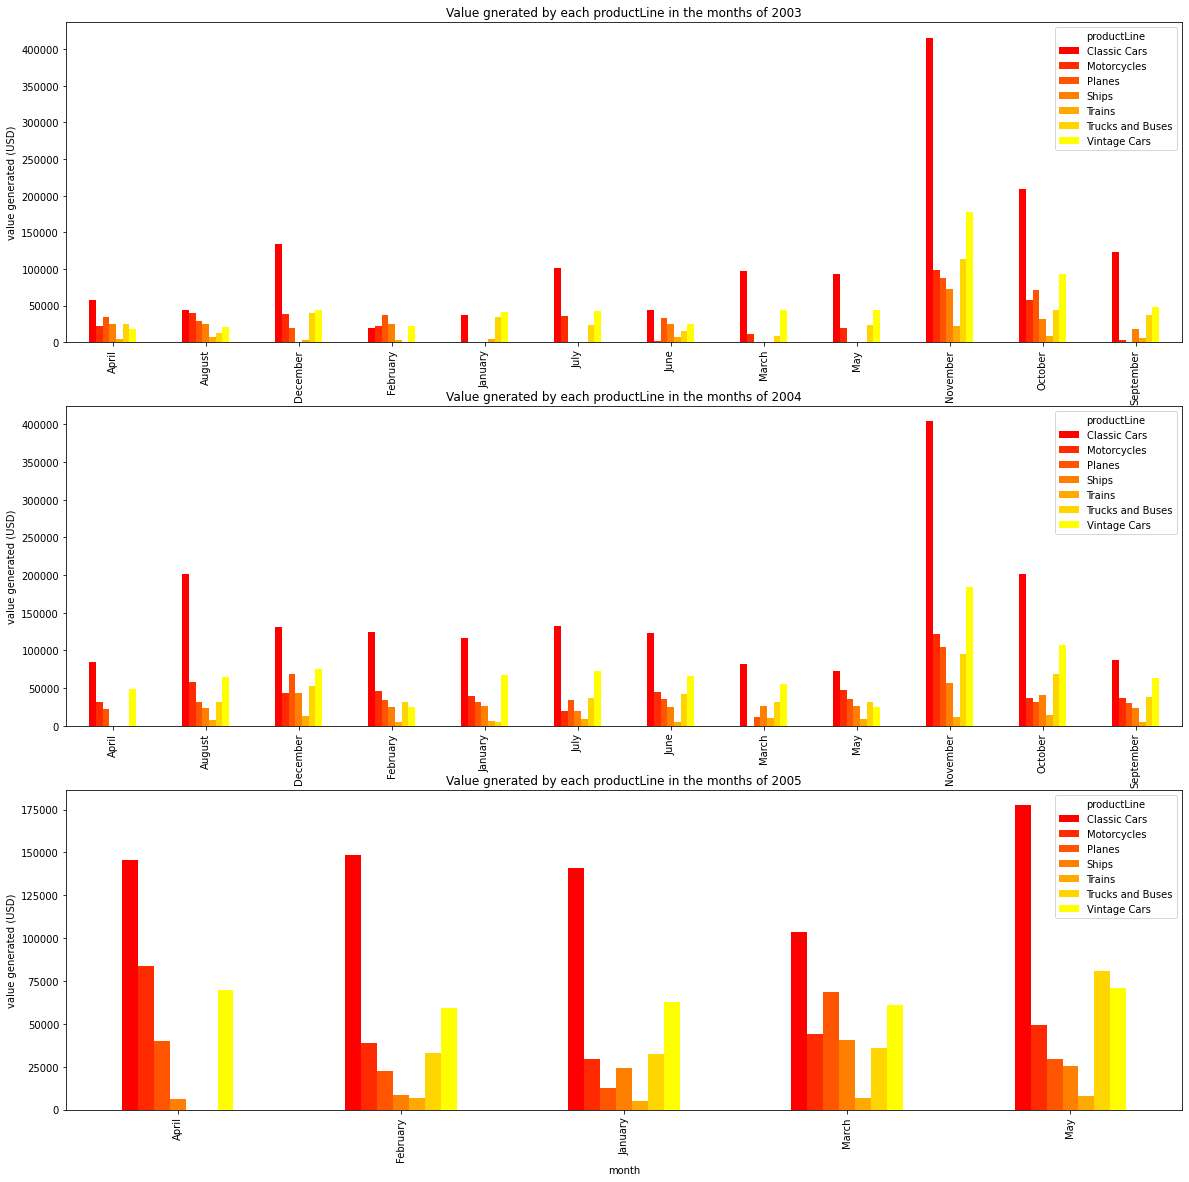

None


In [36]:
merged=products.merge(orderdetails,on="productCode").merge(orders,on="orderNumber")\
[["productLine","productName","value","quantityOrdered","year","month"]]

fig,axes=plt.subplots(3,1,figsize=(20,20))
for i,ax in zip(sorted(merged.year.unique()),axes.ravel()):
    g=merged[merged.year==i].groupby(["month","productLine"])["value"].sum().reset_index()
    p=g.pivot("month","productLine","value").reset_index()
    p.plot(kind="bar",ax=ax,x="month",y=p.columns[1:],colormap="autumn",title="Value gnerated by each productLine in the months of "+str(i),ylabel="value generated (USD)")
print(plt.show())

# Plot the total payments by date and the avg payment for the entire period

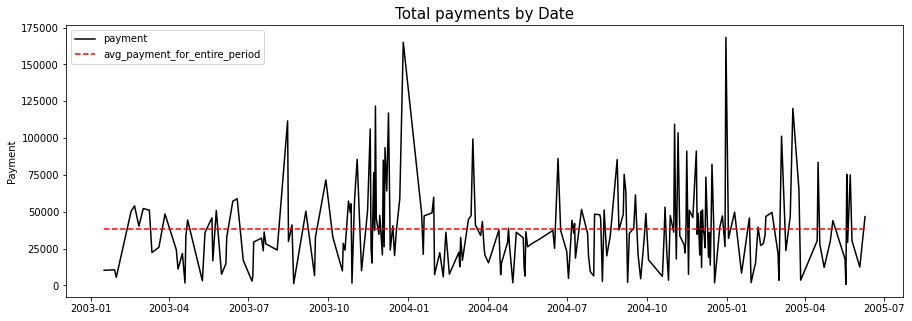

In [54]:
g=payments.groupby("paymentDate")["amount"].sum().reset_index().sort_values("paymentDate")
g["avg_payment"]=g.amount.mean()
plt.figure(figsize=(15,5))
plt.plot(g.paymentDate,g.amount,color="k")
plt.plot(g.paymentDate,g.avg_payment,"r--")
plt.title("Total payments by Date",size=15)
plt.ylabel("Payment")
plt.legend(["payment","avg_payment_for_entire_period"])
plt.show()

# in which months of 2004 was order value higher compared to the same month of 2003

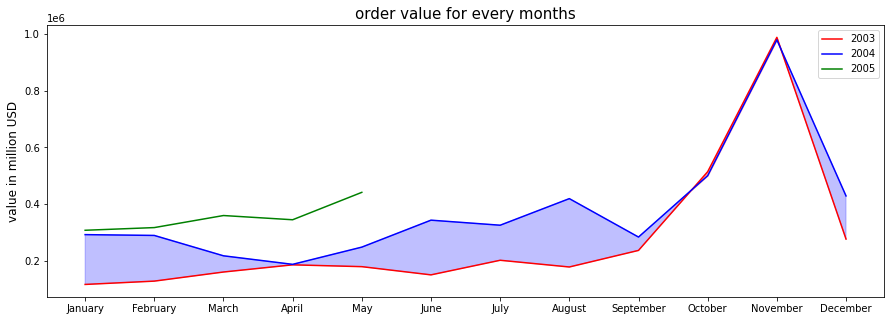

In [60]:
merged=orders.merge(orderdetails,on="orderNumber")[["year","month","monthnum","quantityOrdered","priceEach"]]
merged["value"]=merged.quantityOrdered*merged.priceEach
grouped2003=merged[merged.year==2003].groupby(["monthnum","month"])["value"].sum().reset_index().sort_values("monthnum")
grouped2004=merged[merged.year==2004].groupby(["monthnum","month"])["value"].sum().reset_index().sort_values("monthnum")
grouped2005=merged[merged.year==2005].groupby(["monthnum","month"])["value"].sum().reset_index().sort_values("monthnum")


plt.figure(figsize=(15,5))
plt.plot(grouped2003.month,grouped2003.value,color="r",label=2003)
plt.plot(grouped2004.month,grouped2004.value,color="b",label=2004)
plt.plot(grouped2005.month,grouped2005.value,color="g",label=2005)
plt.fill_between(grouped2003.month,grouped2003.value,grouped2004.value,
        where=(grouped2003.value<grouped2004.value),color="b",interpolate=True,alpha=0.25)
plt.fill_between(grouped2003.month,grouped2003.value,grouped2004.value,
        where=(grouped2003.value>grouped2004.value),color="r",interpolate=True,alpha=0.25)
plt.title("order value for every months",size=15)
plt.ylabel("value in million USD",size=12)
plt.legend()
plt.show()

# Plot the amount of total monthly payments for the entire period 

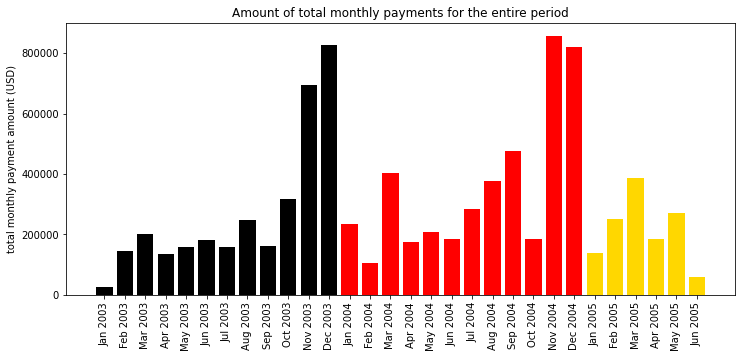

In [34]:
payments["monthnum"]=payments.paymentDate.dt.month
grouped=payments.groupby(["year","month","monthnum"])["amount"].sum().reset_index().sort_values(["year","monthnum"])
grouped["date"]=grouped.month.str[:3]+" "+(grouped.year.astype(str))


colors=["k","r","gold"]
years=grouped.year.unique()
dictionar=dict(zip(years,colors))

plt.figure(figsize=(12,5))
plt.bar(grouped.date,grouped.amount,color=[dictionar[i] for i in grouped.year])
plt.title("Amount of total monthly payments for the entire period")
plt.xticks(rotation=90)
plt.ylabel("total monthly payment amount (USD)")
#plt.legend()
plt.show()

### How total monthly payments was increasing in percentage vs previous month. (How much was the increase from May 2004 to June 2004)

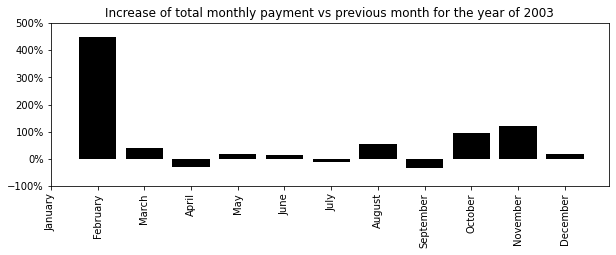

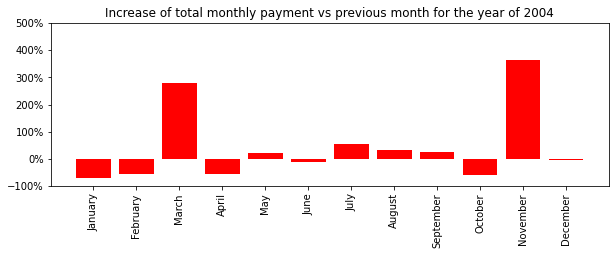

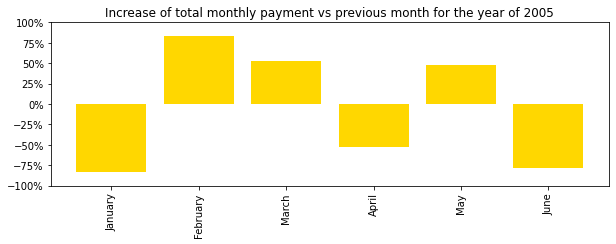

In [26]:
payments["monthnum"]=payments.paymentDate.dt.month
grouped=payments.groupby(["year","month","monthnum"])["amount"].sum().reset_index().sort_values(["year","monthnum"])
grouped["previous_month"]=grouped.amount.shift(1)
grouped["percent"]=100*(grouped.amount-grouped.previous_month)/grouped.previous_month

for y,c in zip(sorted(grouped.year.unique()),["k","r","gold"]):
    g=grouped[grouped.year==y]
    plt.figure(figsize=(10,3))
    plt.bar(g.month,g.percent,color=c)
    plt.title("Increase of total monthly payment vs previous month for the year of "+str(y))
    plt.xticks(g.month,rotation=90)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))
    if y==2005:
        plt.ylim(-100, 100)
    else:
        plt.ylim(-100,500)
    plt.show()

# plot total payments payed vs total order value for each month.(plot on different figures for every year)

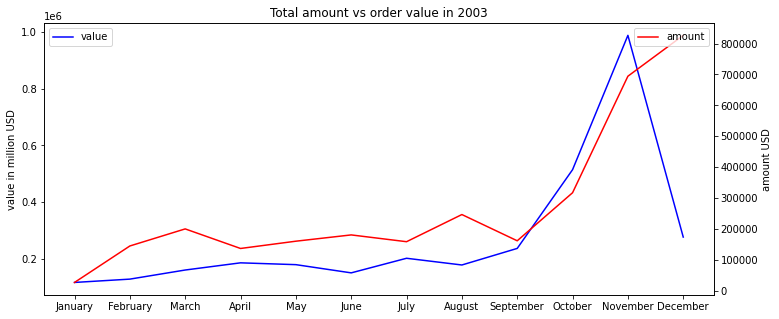

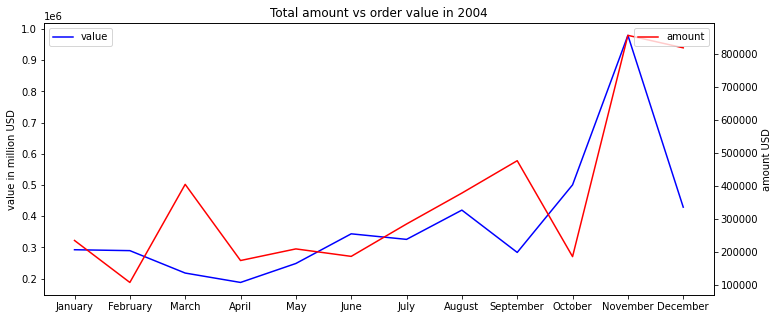

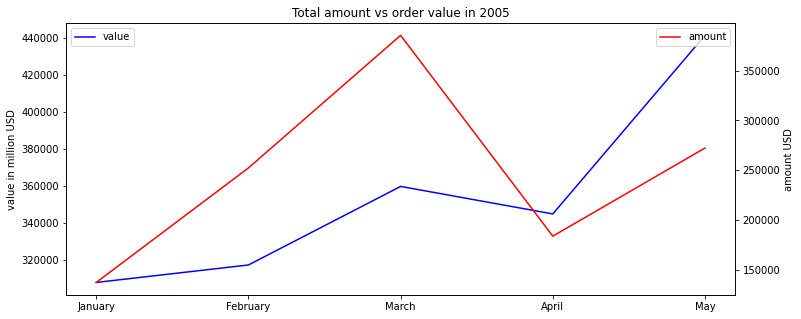

In [96]:
merged=orderdetails.merge(orders,on="orderNumber")[["year","month","monthnum","quantityOrdered","priceEach"]]
merged["value"]=merged.quantityOrdered*merged.priceEach
g1=merged.groupby(["year","monthnum","month"])["value"].sum().reset_index()
g2=payments.groupby(["year","month","monthnum"])["amount"].sum().reset_index()
result=g1.merge(g2,on=["year","month"])

for y in sorted(result.year.unique()):
    g=result[result.year==y].sort_values("monthnum_x")
    fig,ax1=plt.subplots(figsize=(12,5))
    plt.plot(g.month,g.value,color="b",label="value")
    plt.title("Total amount vs order value in "+str(y))
    plt.ylabel("value in million USD")
    plt.legend(loc="upper left")
    
    ax2=ax1.twinx()
    plt.plot(g.month,g.amount,color="r",label="amount")
    plt.legend(loc="upper right")
    plt.ylabel("amount USD")
    plt.show()
    

# plot total payments payed vs total order value for each month.(plot on one chart)

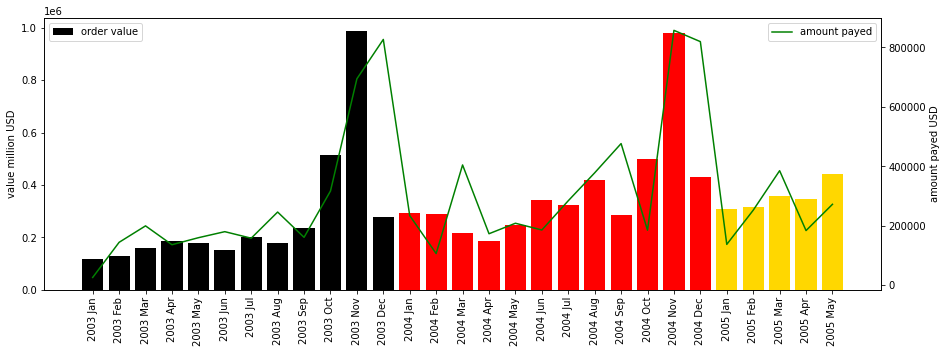

In [146]:
merged=orderdetails.merge(orders,on="orderNumber")[["year","month","monthnum","quantityOrdered","priceEach"]]
merged["value"]=merged.quantityOrdered*merged.priceEach
g1=merged.groupby(["year","monthnum","month"])["value"].sum().reset_index()
g2=payments.groupby(["year","month","monthnum"])["amount"].sum().reset_index()
result=g1.merge(g2,on=["year","month"]).sort_values(["year","monthnum_x"])
result["date"]=result.year.astype(str)+" "+result.month.str[:3]

colors=["black","red","gold"]
years=sorted(result.year.unique())
dictionary=dict(zip(years,colors))

fig,ax1=plt.subplots(figsize=(15,5))
plt.bar(result.date,result.value,color=[dictionary[i] for i in result.year],alpha=1,label="order value")
plt.ylabel("value million USD")
plt.xticks(rotation=90)
plt.legend(loc="upper left")

ax2=ax1.twinx()
plt.plot(result.date,result.amount,color="g",label="amount payed")
plt.legend(loc="upper right")
plt.ylabel("amount payed USD")
plt.show()

# plot clients percentage by country

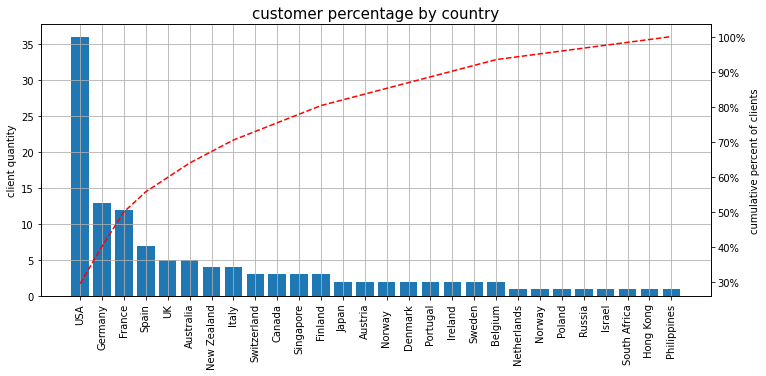

In [73]:
g=customers.groupby("country")["customerName"].count().reset_index().sort_values("customerName",ascending=False)
g["percent"]=100*g.customerName/g.customerName.sum()
g["cum_percent"]=g.percent.cumsum()


fig,ax1=plt.subplots(figsize=(12,5))
plt.bar(g.country,g.customerName,label="quantity")
plt.xticks(g.country,rotation=90)
plt.title("customer percentage by country",size=15)
plt.ylabel("client quantity")
plt.grid(axis="both")
#plt.legend(loc="upper left")


ax2=ax1.twinx()
plt.plot(g.country,g.cum_percent,"r--",label="cumulative percent")
ax2.set_ylabel("cumulative percent of clients")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))
#plt.legend(loc="upper right")

plt.show()

# show employees percentage by country

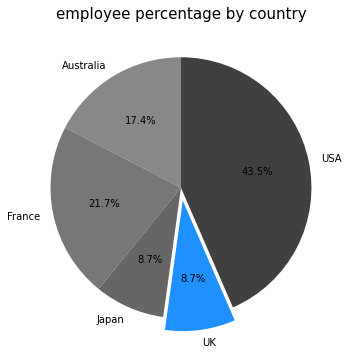

In [59]:
g=employees.merge(offices,on="officeCode").groupby("country")["employeeNumber"].count().reset_index()

plt.figure(figsize=(6,6))
explode=[0,0,0,0.1,0]

cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.55, 0.8, 5)))
colors[3] = 'dodgerblue'

plt.pie(g.employeeNumber,labels=g.country,autopct="%.1f%%",explode=explode,startangle=90,colors=colors)
plt.title("employee percentage by country",size=15)
plt.show()

# find the customers who exceed the credit limit

In [58]:
merged=orderdetails.merge(orders,on="orderNumber")[["customerNumber","quantityOrdered","priceEach"]]
merged["value"]=merged.quantityOrdered*merged.priceEach
g1=merged.groupby("customerNumber")["value"].sum().reset_index()
g2=payments.groupby("customerNumber")["amount"].sum().reset_index()
result=customers.merge(g1,on="customerNumber").merge(g2,on="customerNumber")[["customerName","value","amount"]]
result["difference"]=result.value-result.amount
result["difference"]=result.difference.apply(lambda x:round(x))
final=result[result.difference!=0].merge(customers,on="customerName")[["customerName","value","amount","difference","creditLimit"]]
final[final.creditLimit<final.difference]

,customerName,value,amount,difference,creditLimit
11,Tekni Collectables Inc.,81806.55,38281.51,43525,43000.0
13,Gifts4AllAges.com,84340.32,33533.47,50807,41900.0
18,The Sharp Gifts Warehouse,143536.27,59551.38,83985,77600.0
